In [1]:
from Bio import SeqIO
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md

In [145]:
def calculate_rmsd_mda(gmx_path, pdb_ref_path, high_ids):

    trajectory=md.load(gmx_path + 'traj.xtc', top=gmx_path + 'traj.gro')

    pdb_ref = md.load(pdb_ref_path)
  
    backbone_ref=[] 
    with open(pdb_ref_path, 'r') as file:
        for index, line in enumerate(file):
            columns = line.strip().split()
            if len(columns) >= 4 and columns[2] == "CA":
                backbone_ref.append(index+1)
    
 #   helix = np.concatenate([np.arange(173,219,1), np.arange(266,301,1)]) # P08588
    helix = np.concatenate([np.arange(184,220,1), np.arange(270,300,1)]) # P13945
    
 #   loop = np.concatenate([np.arange(142,170,1), np.arange(300,308,1), np.arange(70,83,1)]) # P08588
 #   loop = np.concatenate([np.arange(153,184,1), np.arange(300,310,1), np.arange(80,90)]) # P13945

    filters = helix # high_ids # helix
    rmsd = md.rmsd(trajectory, pdb_ref, atom_indices=np.array(backbone_ref)[filters], ref_atom_indices=np.array(backbone_ref)[filters])

    return rmsd

In [49]:
def calculate_plddt(path_clusters, path_full):
    
    plddt_file = path_clusters + [file for file in os.listdir(path_clusters) if '_scores_rank_001' in file][0] 
    with open(plddt_file, 'r') as file:
        result_data = json.load(file)
    
    ref_plddt_file = path_full + [file for file in os.listdir(path_full) if '_scores_rank_001' in file][0] 
    with open(ref_plddt_file, 'r') as file:
        ref_data = json.load(file)

    plddt_local = result_data['plddt']
    high_ids = np.where(np.array(ref_data['plddt']) > 70)
    plddt_avg = np.mean(plddt_local)
    
    return plddt_avg, high_ids

In [42]:
def count_sequences_in_fasta(path_msa):
    sequence_count = sum(1 for _ in SeqIO.parse(path_msa, "fasta"))
    return sequence_count

In [102]:
def exclude_low_avg_plddt(clu_ids, rmsd, plddt, size):
    ids = np.where(np.array(plddt) > 70)[0]
    return np.array(clu_ids)[ids], np.array(rmsd)[ids], np.array(plddt)[ids], np.array(size)[ids]

In [141]:
def plot(clu_ids, rmsd, plddt, size, name):
    os.makedirs('results_figures', exist_ok=True)
    
    fig, ax = plt.subplots(figsize=(13,5))

    clu_ids, rmsd, plddt, size = exclude_low_avg_plddt(clu_ids, rmsd, plddt, size)
    sc = plt.scatter(clu_ids, rmsd, cmap='rainbow_r', s=size, c=plddt) 
    cbar = plt.colorbar(sc, ax=ax, pad=0.02, label='plDDT')
    plt.title(name + ' helices 5 and 6')
    plt.xlabel('cluster_id')
    plt.ylabel('RMSD from full MSA AlphaFold2 prediction')
    plt.xticks(rotation=90)
    plt.grid(True, which='both', axis='both', color='gray', linestyle='--', linewidth=0.4)
    plt.xlim(left=-1,right=len(rmsd)+0.2)

    plt.tight_layout()
    plt.show()
    fig.savefig('results_figures/' + name+'_helices.png',dpi=500, format='png')

In [97]:
def main(name):
    
    path_full =  name + '/AF_full/'
    path_clusters =  name + '/AF_clusters/'
    gmx_path =  name + '/gmx_traj/'
    ref_pdb = gmx_path + 'fullMSA_noH.pdb' 
    
    plddt = []
    size = []
    clu_ids = os.listdir(path_clusters)
    sorted_clu_ids = sorted(clu_ids, key=lambda x: int(x.split('_')[-1]) if '_' in x and x.split('_')[-1].isdigit() else float('inf'))

    for clu_id in sorted_clu_ids:
        
        path_cluster = path_clusters + clu_id +'/' 
        path_msa = name + '/clusters/' + clu_id + '.fasta'  
        
        cluster_pdb = path_clusters + clu_id + '/' + [file for file in os.listdir(path_cluster) if '_relaxed_rank_001' in file][0]
    
        plddt_val, high_ids = calculate_plddt(path_cluster, path_full)
        plddt.append(plddt_val)
        size.append(count_sequences_in_fasta(path_msa))
    
    rmsd = calculate_rmsd_mda(gmx_path, ref_pdb, high_ids)

    np.save(gmx_path+'rmsd.npy', rmsd)
    np.save(gmx_path+'plddt.npy', plddt)
    np.save(gmx_path+'size.npy', size)
    plot(sorted_clu_ids, rmsd, plddt, size, name)

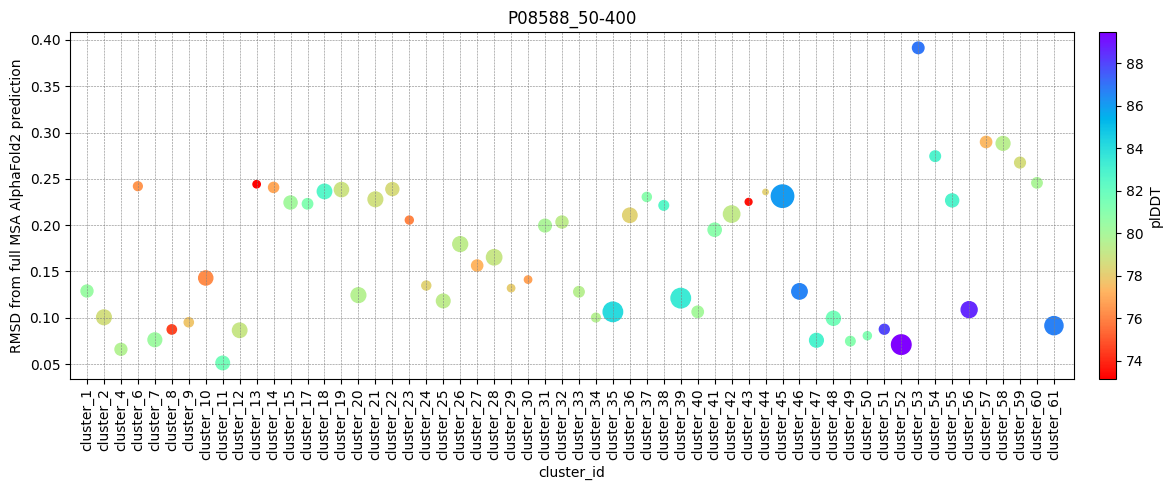

In [108]:
name = 'P08588_50-400' 
main(name)

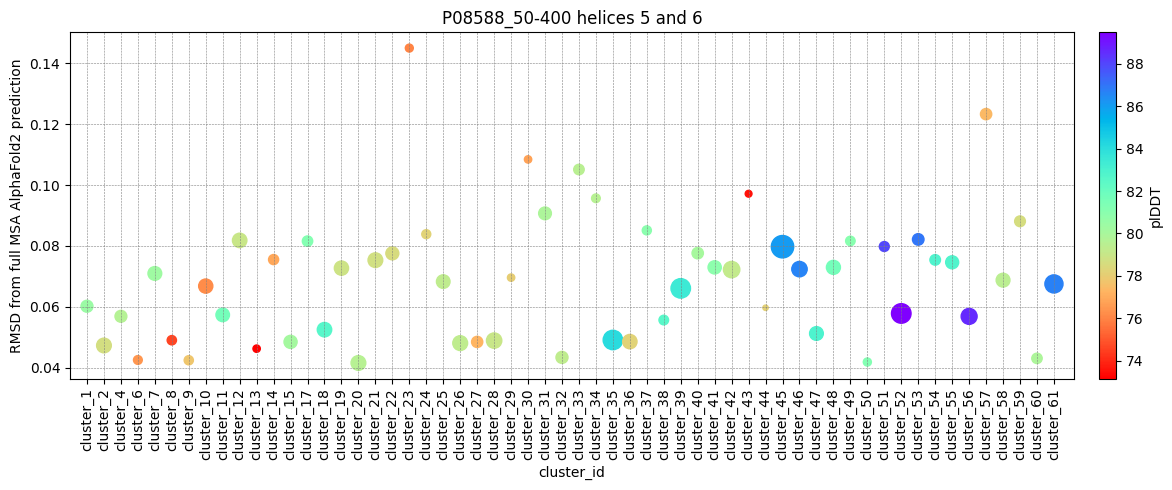

In [142]:
name = 'P08588_50-400' 
main(name)

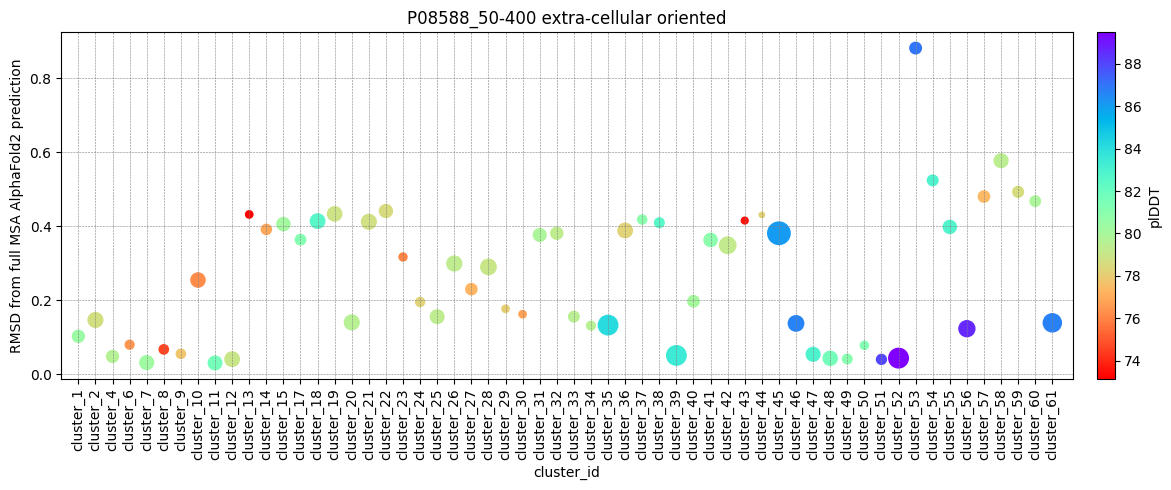

In [139]:
name = 'P08588_50-400' 
main(name)

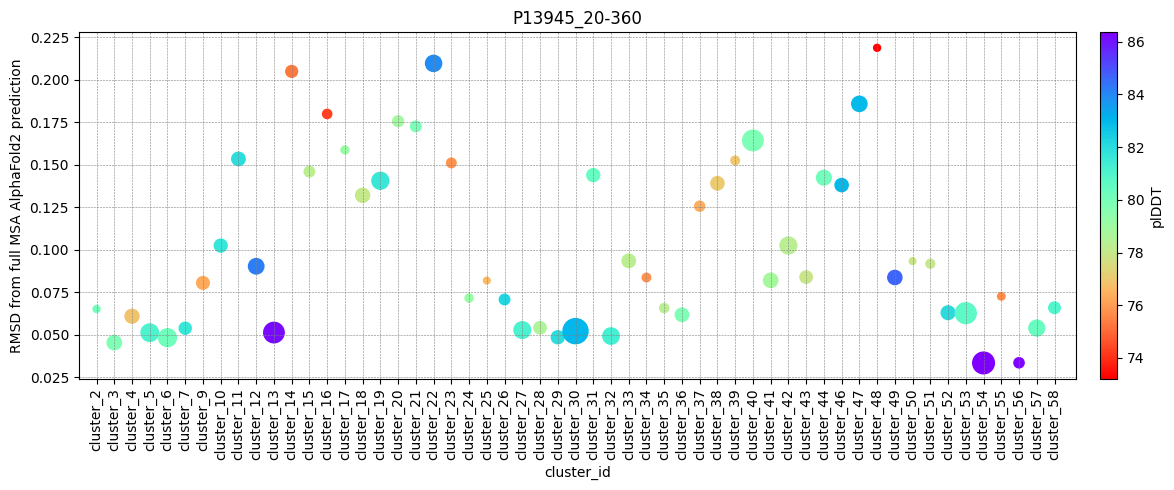

In [121]:
name = 'P13945_20-360' 
main(name)

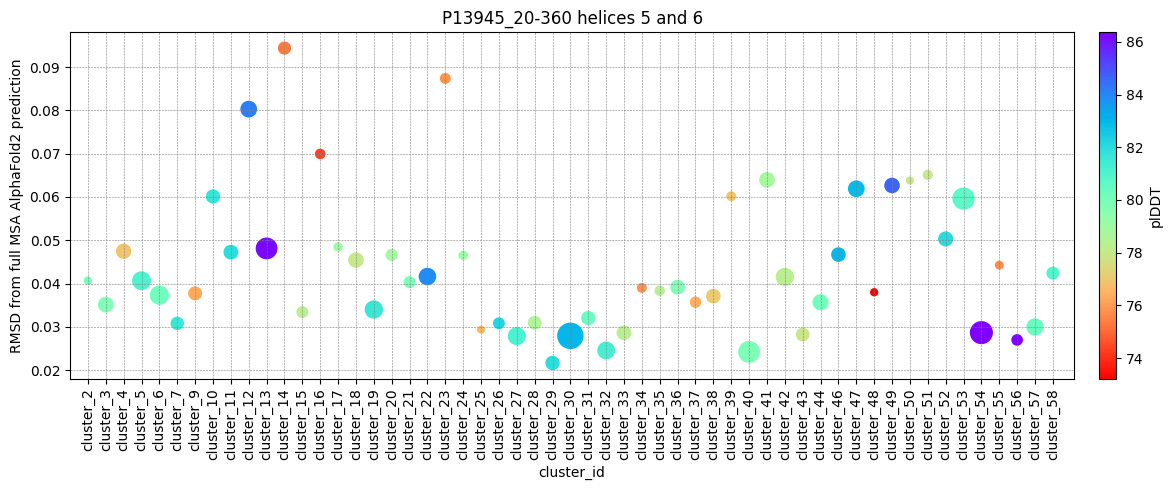

In [146]:
name = 'P13945_20-360' 
main(name)